In [210]:
#Hello

In [211]:
import os
import pandas as pd
from torch.utils.data import DataLoader
from datetime import datetime

Load Datasets

In [212]:
#Load the fight data
fight_stats_df = pd.read_csv('datasets/ufc_fight_stat_data.csv')

#Load fight data
fight_data_df = pd.read_csv('datasets/ufc_fight_data.csv')

#Load fighter data 
fighter_data_df = pd.read_csv('datasets/ufc_fighter_data.csv')

#Load event data
event_data_df = pd.read_csv('datasets/ufc_event_data.csv')

print(fighter_data_df.columns)

Index(['fighter_id', 'fighter_f_name', 'fighter_l_name', 'fighter_nickname',
       'fighter_height_cm', 'fighter_weight_lbs', 'fighter_reach_cm',
       'fighter_stance', 'fighter_dob', 'fighter_w', 'fighter_l', 'fighter_d',
       'fighter_nc_dq', 'fighter_url'],
      dtype='object')


Clean and Process Data

In [213]:
#Convert data columns to datetime format
fighter_data_df['fighter_dob'] = pd.to_datetime(fighter_data_df['fighter_dob'])

#Handle Missing Value, if any
fight_stats_df = fight_stats_df.dropna(subset=['fighter_id', 'ctrl_time'])
fight_data_df = fight_data_df.dropna(subset=['fight_id', 'f_1', 'f_2', 'winner', 'num_rounds'])
fighter_data_df = fighter_data_df.dropna(subset=['fighter_id', 'fighter_reach_cm', 'fighter_height_cm', 'fighter_stance', 'fighter_dob'])

fighter_data_df['fighter_nc_dq'] = fighter_data_df['fighter_nc_dq'].fillna(0)
fighter_data_df['fighter_stance'] = fighter_data_df['fighter_stance'].fillna(0)

event_data_df = event_data_df.dropna(subset=['event_id'])

#Encode categorical variables (if needed)
fighter_data_df['fighter_stance'] = fighter_data_df['fighter_stance'].map({'Orthodox': 0, 'Southpaw': 1, 'Switch': 2})



Merge Datasets

In [214]:
    
merged_df = pd.merge(fight_stats_df, fight_data_df, how='inner', on='fight_id')
merged_df = pd.merge(merged_df, fighter_data_df, how='inner', on='fighter_id')
merged_df = pd.merge(merged_df, event_data_df, how='inner', on='event_id')


Cleaning

In [215]:
# Convert ctrl_time from minute format to seconds
def time_to_seconds(time_str):
    if time_str == '--':
        return None  # or any other suitable value, like np.nan
    else:
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds
    
merged_df['ctrl_time'] = merged_df['ctrl_time'].apply(time_to_seconds)
merged_df['finish_time'] = merged_df['finish_time'].apply(time_to_seconds)

#Convert each column to unique ID
merged_df['referee'] = pd.factorize(merged_df['referee'])[0]
merged_df['event_city'] = pd.factorize(merged_df['event_city'])[0]
merged_df['event_state'] = pd.factorize(merged_df['event_state'])[0]
merged_df['event_country'] = pd.factorize(merged_df['event_country'])[0]
merged_df['result_details'] = pd.factorize(merged_df['result_details'])[0]
merged_df['title_fight'] = pd.factorize(merged_df['title_fight'])[0]
merged_df['weight_class'] = pd.factorize(merged_df['weight_class'])[0]
merged_df['gender'] = pd.factorize(merged_df['gender'])[0]
merged_df['result'] = pd.factorize(merged_df['result'])[0]

# NOTE: add column that contains value age at the event date

# Convert num_rounds to int
merged_df['num_rounds'] = pd.to_numeric(merged_df['num_rounds'], errors='coerce')


# Convert dob to age in years at the date of 3/25/2024
hard_coded_datetime = datetime(2024, 3, 25)
merged_df['fighter_dob'] = (hard_coded_datetime.date() - pd.to_datetime(merged_df['fighter_dob']).dt.date).apply(lambda x: x.days / 365.25)


# List of columns to drop (temp drop 'event_date' *add later*)
cols_to_drop = ['fight_url_x', 'fighter_url', 'event_url', 'fight_url_x', 'fight_url_y', 'event_url', 'fighter_url', 'event_name', 'fighter_nickname', 'fighter_l_name', 'fighter_f_name', 'event_date', 'event_state', 'fight_id']

# Drop the specified columns
merged_df = merged_df.drop(columns=cols_to_drop)


# merged_df = pd.read_csv('final_set.csv')
merged_df.to_csv('final.csv', index=False)

print(merged_df.columns)
print("num of columns" , merged_df.shape[1])

Index(['fight_stat_id', 'fighter_id', 'knockdowns', 'total_strikes_att',
       'total_strikes_succ', 'sig_strikes_att', 'sig_strikes_succ',
       'takedown_att', 'takedown_succ', 'submission_att', 'reversals',
       'ctrl_time', 'event_id', 'referee', 'f_1', 'f_2', 'winner',
       'num_rounds', 'title_fight', 'weight_class', 'gender', 'result',
       'result_details', 'finish_round', 'finish_time', 'fighter_height_cm',
       'fighter_weight_lbs', 'fighter_reach_cm', 'fighter_stance',
       'fighter_dob', 'fighter_w', 'fighter_l', 'fighter_d', 'fighter_nc_dq',
       'event_city', 'event_country'],
      dtype='object')
num of columns 36


Random Forrest Algo

In [259]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

data = merged_df
df = pd.DataFrame(data)

# Creating a binary target variable indicating whether the fighter won or not.
df['is_winner'] = df['fighter_id'] == df['winner']

# Selecting features for the model
features = [
    "knockdowns", "total_strikes_att", "total_strikes_succ", 
    "sig_strikes_att", "sig_strikes_succ", "takedown_att", 
    "takedown_succ", "submission_att", "reversals", "ctrl_time",
    "num_rounds", "title_fight", "weight_class", "gender", 
    "fighter_height_cm", "fighter_weight_lbs", "fighter_reach_cm", 
    "fighter_stance", "fighter_w", "fighter_l", "fighter_d"
]
X = df[features]
y = df['is_winner']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizing the feature set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predicting and evaluating the model
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.7970903522205207


Preprocessing for nn

In [262]:
import numpy as np
import pandas as pd

#X_train_scaled is a numpy array; convert it to a DataFrame for easier manipulation
df_train_features = pd.DataFrame(X_train_scaled)

# Handling NaN values by imputation
df_train_features.fillna(df_train_features.mean(), inplace=True)

# Handling infinite values by replacing them with NaN and then imputing
df_train_features.replace([np.inf, -np.inf], np.nan, inplace=True)
df_train_features.fillna(df_train_features.mean(), inplace=True)

# Convert back to numpy array if necessary
X_train_scaled_clean = df_train_features.to_numpy()


Example check for NaNs or infinite values in numpy


In [218]:
# Example check for NaNs or infinite values in numpy
import numpy as np

# Assuming X_train_scaled is a numpy array
if np.isnan(X_train_scaled).any() or np.isinf(X_train_scaled).any():
    print("Training features contain NaN or infinite values.")
if np.isnan(y_train.values).any():
    print("Training labels contain NaN values.")
    

Neural Network

In [257]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt


# Convert data to PyTorch tensors, ensuring y_train and y_test are converted from pandas Series to numpy arrays first
X_train_tensor = torch.tensor(X_train_scaled).float()
y_train_tensor = torch.tensor(y_train.to_numpy()).long()  
X_test_tensor = torch.tensor(X_test_scaled).float()
y_test_tensor = torch.tensor(y_test.to_numpy()).long()

# Creating Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Splitting train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Neural Network Model with Dropout
class FightPredictor(nn.Module):
    def __init__(self):
        super(FightPredictor, self).__init__()
        self.fc1 = nn.Linear(X_train_scaled.shape[1], 128)
        self.dropout1 = nn.Dropout(0.5)  # Adding dropout
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)  # Adding dropout
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = FightPredictor()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Training with Early Stopping
num_epochs = 50
best_val_loss = float('inf')

training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    training_loss = running_loss / len(train_loader)
    training_losses.append(training_loss)

    # Validation loss
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    validation_loss = val_loss / len(val_loader)
    validation_losses.append(validation_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    
    scheduler.step()  # Update learning rate
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')

# Load the best model for testing
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test dataset: {100 * correct / total}%')


Epoch 1/50, Training Loss: 0.5885039165274788, Validation Loss: 0.4900535561821677
Epoch 2/50, Training Loss: 0.5091220056282655, Validation Loss: 0.46712077928311896
Epoch 3/50, Training Loss: 0.4916233029074341, Validation Loss: 0.45940844308246265
Epoch 4/50, Training Loss: 0.4789361605662426, Validation Loss: 0.45555490345665905
Epoch 5/50, Training Loss: 0.4665062925742783, Validation Loss: 0.449075283426227
Epoch 6/50, Training Loss: 0.46810443494611115, Validation Loss: 0.44545676401167206
Epoch 7/50, Training Loss: 0.45829800613053884, Validation Loss: 0.4423823185039289
Epoch 8/50, Training Loss: 0.45260445784976466, Validation Loss: 0.43988062396193994
Epoch 9/50, Training Loss: 0.44568021220105297, Validation Loss: 0.44075270493825275
Epoch 10/50, Training Loss: 0.45020561796108277, Validation Loss: 0.4435925113432335
Epoch 11/50, Training Loss: 0.44471508241791763, Validation Loss: 0.43849309195171704
Epoch 12/50, Training Loss: 0.44229153867896276, Validation Loss: 0.43821

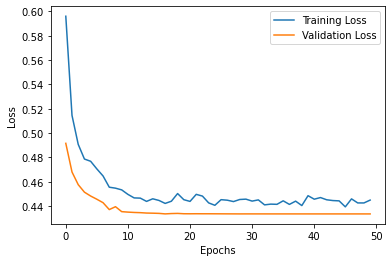

In [253]:
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
